# Sliding window object detection using HOG

In [1]:
# importing libs
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from skimage.feature import hog


## Loading Training Data

In [2]:
# reading data
import glob

train_images = []
train_images_labels = []
test_images = []

for i in glob.glob('data/deer-train/*.jpg'):
    img = cv.imread(i,cv.IMREAD_GRAYSCALE)
    img = cv.resize(img,(224,224))
    train_images.append(img)
    train_images_labels.append(i.split('_')[-1].split('.')[0])
    
label_dict = {'nd':0,'d':1}
train_images_labels  = [label_dict[_] for _ in train_images_labels]

## Code of increasing dataset

In [3]:
# # randomcrop images and add to train_images
# for i in range(0,len(train_images[:2])):
#     x = np.random.randint(0,224)
#     y = np.random.randint(0,224)
#     if x >112 or y>112:
#         x = abs(x-112)
#         y = abs(y-112)
#     img = train_images[i][x:x+224,y:y+224]
#     img = cv.resize(img,(224,224))
#     train_images.append(img)
#     train_images_labels.append('nd')

In [4]:
train_images_labels.count('nd'),train_images_labels.count('d')

(0, 0)

## Plotting random images

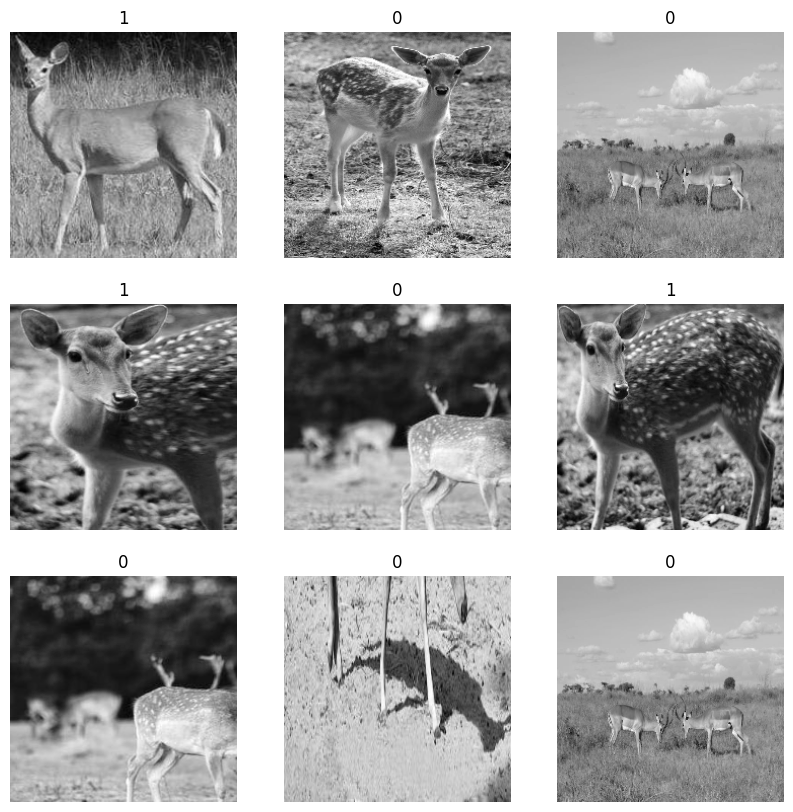

In [5]:
# plotting 9 images and labels
random_idx = np.random.randint(0,len(train_images),9)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[random_idx[i]], cmap="gray")
    plt.title(train_images_labels[random_idx[i]])
    plt.axis('off')
plt.show()


## Creating hog descriptor

In [6]:
# creating hog descriptor
train_hog_images = []
feature_images = []
for i in range(len(train_images)):
    feature, hog_image = hog(train_images[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    train_hog_images.append(hog_image)
    feature_images.append(feature)

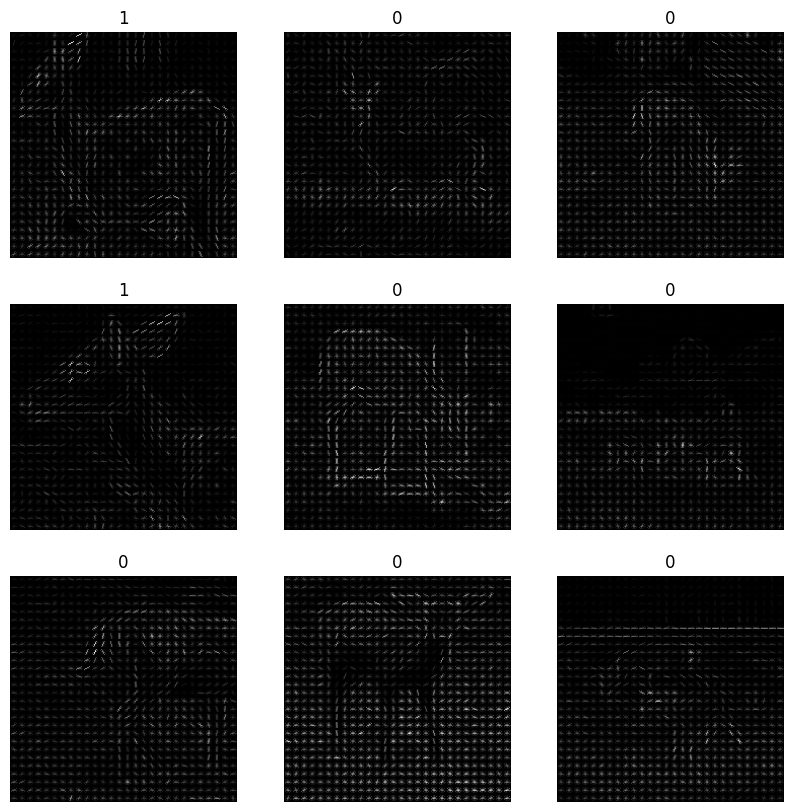

In [7]:
# plotting 9 hog images and labels
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_hog_images[i].reshape(224,224), cmap="gray")
    plt.title(train_images_labels[i])
    plt.axis('off')
plt.show()


## Traing Classifier

In [8]:
# creating classifier
clf = SVC(kernel='rbf', C=1.0, random_state=42)
hog_features = np.array(feature_images)
data_labels = np.array(train_images_labels)
train_data = np.hstack((hog_features, data_labels.reshape(-1,1)))
np.random.shuffle(train_data)

clf.fit(train_data[:,:-1], train_data[:,-1])
clf

SVC(random_state=42)

## Testing and dawing on Test dataset

In [9]:
# loading test data
test_images = []
for i in glob.glob('data/deer-test/*.*'):
    img = cv.imread(i,cv.IMREAD_GRAYSCALE)
    img = cv.resize(img,(1024,1024))
    test_images.append(img)
print(f"len of test images: {len(test_images)}")

len of test images: 8


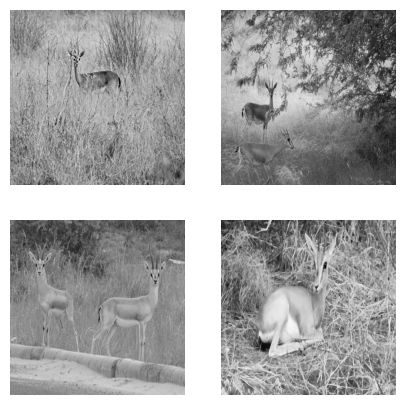

In [10]:
# plotting 4 images and labels from test data
plt.figure(figsize=(5,5))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(test_images[i], cmap="gray")
    plt.axis('off')
plt.show()


In [11]:
# applying sliding window
window_size = (224, 224)
step_size = 112
locations = []
images_all_patches = []
for img in test_images:
    for y in range(0, img.shape[0]-window_size[1], step_size):
        for x in range(0, img.shape[1]-window_size[0], step_size):
            locations.append((x, y, img[y:y+window_size[1], x:x+window_size[0]]))
    images_all_patches.append(locations)

In [12]:
print(f"len of images_all_patches: {len(images_all_patches[0])}")

len of images_all_patches: 512


### Plotting random Patches form test samples

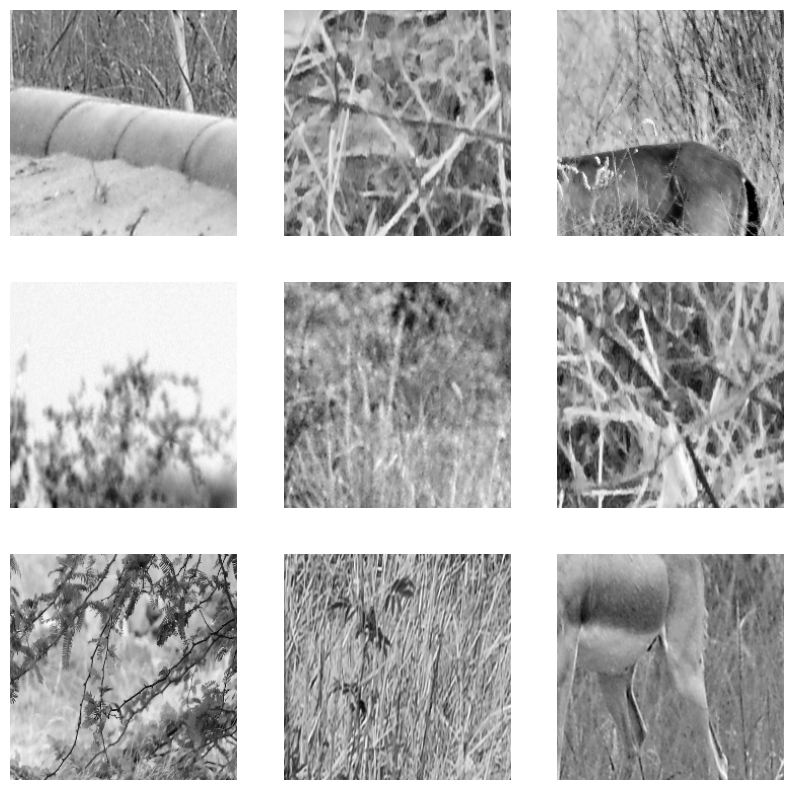

In [13]:
# plotting locations from test images
plt.figure(figsize=(10,10))
random_indexs = np.random.randint(0, len(locations), 9)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(locations[random_indexs[i]][2], cmap="gray")
    plt.axis('off')

## computing & plotting final boundedd boxes images

In [14]:
# moving hog descriptor to sliding window and applying classifier
i = 0
for img_patch in images_all_patches:
    for img in img_patch:
        feature, hog_image = hog(img[2], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_image = hog_image.reshape(1, -1)
        prediction = clf.predict(feature.reshape(1, -1))
        # print(prediction)
        if prediction[0] == 1:
            # print(f"deer found at {img[0], img[1]}")
            cv.rectangle(test_images[i], (img[0],img[1]), (224,225), (0, 255, 0), 2)
            # cv.putText(img[2], 'deer', (img[0], img[1]), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)
    i += 1

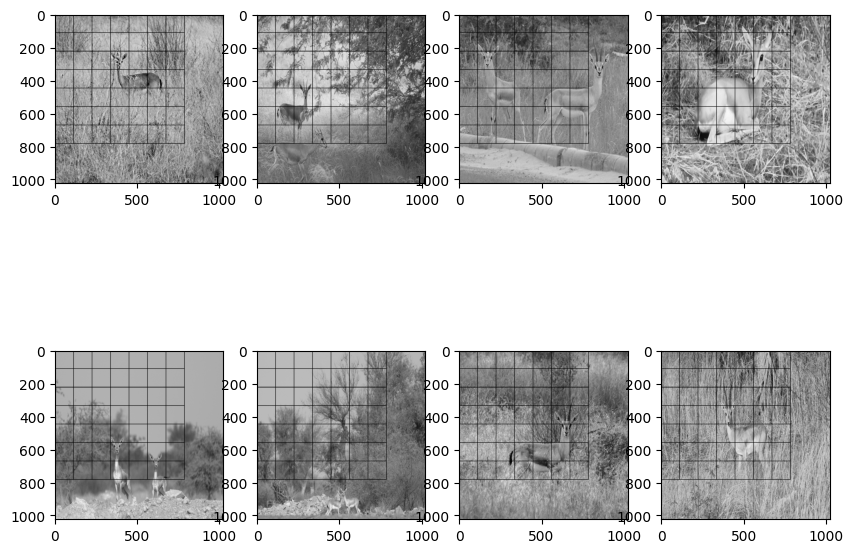

In [18]:
plt.figure(figsize=(10,8))
for i in range(len(test_images)):
    plt.subplot(2,len(test_images)//2,i+1)
    plt.imshow(test_images[i], cmap="gray")
plt.show()